## Homework 4
## Shaorong Zhang (SID: 862394226)

In [1]:
import numpy as np
import random
from torchvision.datasets import MNIST
import time
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Configuration
print_every = 1000
record_every = 1000
N_epochs = 80
batch_size = 64
N_train, N_test = 10000, 10000
N_batches = int(N_train / batch_size)

In [3]:
def get_sampled_indeces():
    # Download the training and test data
    cifar_train = MNIST(root='./data', train=True, download=True)

    # Separate the dataset into class-wise indices
    class_indices = [[] for _ in range(10)]
    for i, (data, target) in enumerate(cifar_train):
        class_indices[target].append(i)

    # # Sample 1,000 examples for each class
    sampled_indeces = []
    for indices in class_indices:
        indices = np.array(indices)
        indices_rand = random.sample(range(5000),int(N_train/10))
        sampled_indeces.extend(indices[indices_rand])
    return sampled_indeces
SAMPLED_INDECES = get_sampled_indeces()
len(SAMPLED_INDECES)

10000

In [4]:
def get_eva_data(dataset):
    for data, target in dataset:
        X = data
        y = target
    return X, y

In [5]:
# Function of formatting the data
def Formatting_data(train = True):
    # Download the training and test data
    mnist = MNIST(root='./data', train=train, download=True)
    # Convert inputs x to vectors of size 28 2= 784.
    X, targets = mnist.data.view(-1,784).float(), mnist.targets
    # Standardize input images using z-normalization
    X = (X - torch.mean(X))/torch.std(X)
    if train == True: 
        return X[SAMPLED_INDECES], targets[SAMPLED_INDECES]
    else: return X, targets

In [6]:
def ToOneHot(dataset):
    features = []
    labels = []
    for data, target in dataset:
        features.append(data)
        labels.append(target)

    # Convert labels to one-hot encoded representation
    labels_onehot = torch.zeros(len(labels), 10)
    for i in range(len(labels)):
        labels_onehot[i, labels[i]] = 1

    # Create a new dataset with one-hot encoded labels
    new_dataset = TensorDataset(torch.stack(features), labels_onehot)
    return new_dataset

In [7]:
# Formatting the data
X_train, y_train = Formatting_data(train = True)
X_test, y_test = Formatting_data(train = False)

# Use data loader
train_loader = DataLoader(dataset=ToOneHot(TensorDataset(X_train, y_train)), batch_size=batch_size, shuffle=True)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10000, 784]),
 torch.Size([10000, 784]),
 torch.Size([10000]),
 torch.Size([10000]))

## Shallow Neural Net Classifer

In [9]:
class ShallowNet(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, p=0.5):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        # nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x
    
def get_acc(y, y_hat):
    # y = torch.max(y, 1)[1]
    y_hat = torch.max(y_hat, 1)[1]
    acc = (y==y_hat).sum() / len(y)
    acc = acc.cpu()
    return acc

# plot Training and Test accuracy
def Plot_Acc(K, P):
      plt.figure(figsize=(10,3), dpi = 300)
      for k in K:
          for p in P:
            Loss, Acc_train, Acc_test = torch.load("./data/result_k{}_p{}".format(k, p))
            t = range(len(Loss))
            plt.subplot(1,3,1)
            plt.plot(t, Loss, label = 'k={}, p={}'.format(k, p))
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.legend(fontsize=7)
            plt.subplot(1,3,2)
            plt.plot(t, Acc_train, label = 'k={}, p={}'.format(k, p))
            plt.xlabel("Iteration")
            plt.ylabel("Training accuracy")
            plt.legend(fontsize=7)
            plt.subplot(1,3,3)
            plt.plot(t, Acc_test, label = 'k={}, p={}'.format(k, p))
            plt.xlabel("Iteration")
            plt.ylabel("Test accuracy")
            plt.legend(fontsize=7)
            plt.tight_layout()

In [10]:
def train(K, P, noise = False):
    for k in K:
        for p in P:
            model = ShallowNet(hidden_dim=k, p=p)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.CrossEntropyLoss()
            # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.75)

            Loss = []
            Acc_train = []
            Acc_test = []
            for epoch in range(N_epochs):
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    output = model(inputs)
                    loss = criterion(output, targets)
                    loss.backward()
                    optimizer.step()

                # evaluation
                # scheduler.step()
                model.eval()
                with torch.no_grad():
                    y_train_hat = model(X_train)
                    acc_train = get_acc(y_train, y_train_hat)
                    Acc_train.append(acc_train)
                    y_test_hat = model(X_test)
                    acc_test = get_acc(y_test, y_test_hat)
                    Acc_test.append(acc_test)
                    Loss.append(loss.item())
                    print(f"K = {k},P = {p}, epoch: {epoch+1}, training loss: {loss.item():.4f}, training acc: {acc_train*100:.2f}%, test acc: {acc_test*100:.2f}%")
                
            if noise:
                torch.save([Loss, Acc_train, Acc_test], "./data/result_noise_k{}_p{}".format(k, p))
            else:
                torch.save([Loss, Acc_train, Acc_test], "./data/result_k{}_p{}".format(k, p))



In [11]:
# Train the model
K = [1,5,10,20,40]
P = [0.1, 0.5, 1.0]
N_epochs = 80
train(K = K, P = P)


K=1,P=0.1, epoch: 1, training loss: 2.0945, training acc: 16.11%, test acc: 16.75%
K=1,P=0.1, epoch: 2, training loss: 2.3216, training acc: 17.76%, test acc: 18.16%
K=1,P=0.1, epoch: 3, training loss: 2.2569, training acc: 18.55%, test acc: 18.80%
K=1,P=0.1, epoch: 4, training loss: 2.3067, training acc: 18.66%, test acc: 18.93%
K=1,P=0.1, epoch: 5, training loss: 2.1907, training acc: 18.55%, test acc: 18.83%
K=1,P=0.1, epoch: 6, training loss: 2.2339, training acc: 18.44%, test acc: 18.62%
K=1,P=0.1, epoch: 7, training loss: 2.2670, training acc: 18.63%, test acc: 18.83%
K=1,P=0.1, epoch: 8, training loss: 2.2981, training acc: 18.75%, test acc: 18.88%
K=1,P=0.1, epoch: 9, training loss: 2.0951, training acc: 18.77%, test acc: 18.94%
K=1,P=0.1, epoch: 10, training loss: 2.1353, training acc: 18.89%, test acc: 18.98%
K=1,P=0.1, epoch: 11, training loss: 2.2000, training acc: 18.12%, test acc: 18.36%
K=1,P=0.1, epoch: 12, training loss: 2.2866, training acc: 17.93%, test acc: 18.20%
K

In [12]:
# Read the training and test acc to a table
K = [1,5,10,20,40]
P = [0.1, 0.5, 1.0]
Acc_train_total = np.zeros((len(K), len(P)))
Acc_test_total = np.zeros((len(K), len(P)))
for i, k in enumerate(K):
    for j, p in enumerate(P):
            _, Acc_train, Acc_test = torch.load("./data/result_k{}_p{}".format(k, p))
            Acc_train_total[i][j] = Acc_train[-1].numpy()
            Acc_test_total[i][j] = Acc_test[-1].numpy()
Acc_train_total, Acc_test_total

(array([[0.29159999, 0.3335    , 0.31760001],
        [0.92860001, 0.92290002, 0.92119998],
        [0.96609998, 0.88020003, 0.96569997],
        [0.98070002, 0.97680002, 0.9781    ],
        [0.98540002, 0.9885    , 0.98710001]]),
 array([[0.2951    , 0.3186    , 0.2895    ],
        [0.87440002, 0.86900002, 0.87989998],
        [0.92229998, 0.83780003, 0.91979998],
        [0.9325    , 0.93529999, 0.93049997],
        [0.94770002, 0.95109999, 0.94190001]]))

#### 2.1 Fix p = 1.0 which is the case of “no dropout regularization”. Plot the test and training accuracy as a function of k. As k increases, does the performance improve? At what k, training accuracy becomes 100%?

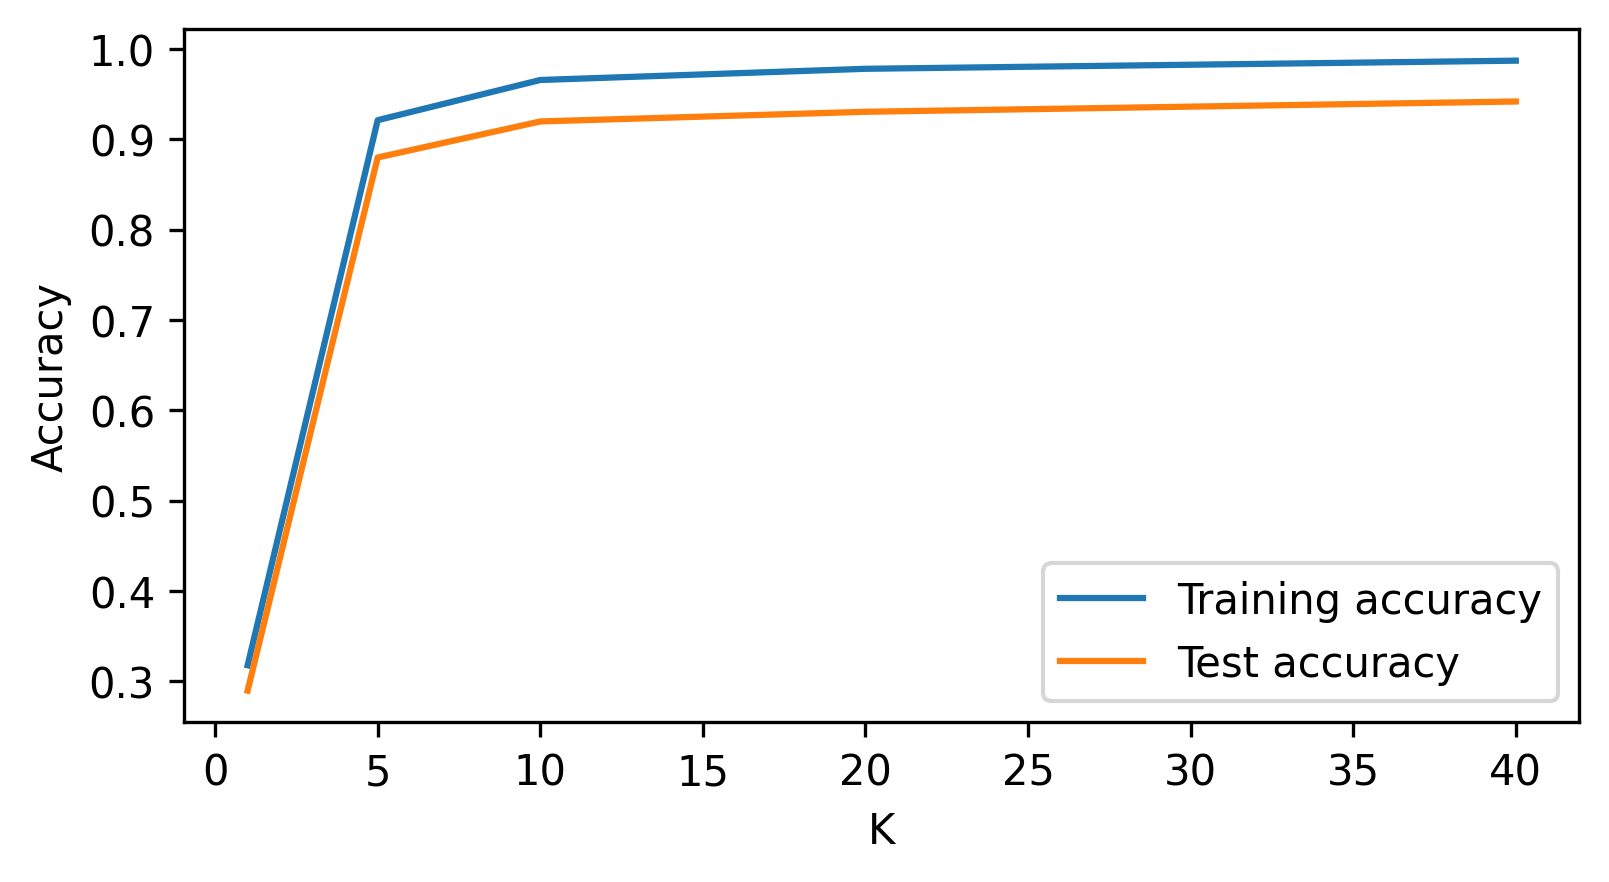

In [13]:
# Fix p = 1.0
plt.figure(figsize=(6,3), dpi=300)
plt.plot(K, Acc_train_total[:, -1], label = "Training accuracy")
plt.plot(K, Acc_test_total[:, -1], label = "Test accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
# plt.title("Training and test accuracy with p = 1.0")
plt.legend()

#### 2.2 Plot the training accuracy as a function of k and for different p ∈ P on the same plot. What is the role of p on training accuracy? When p is smaller, is it easier to optimize or more difficult? For each choice of p, determine at what choice of k, training accuracy becomes 100%.

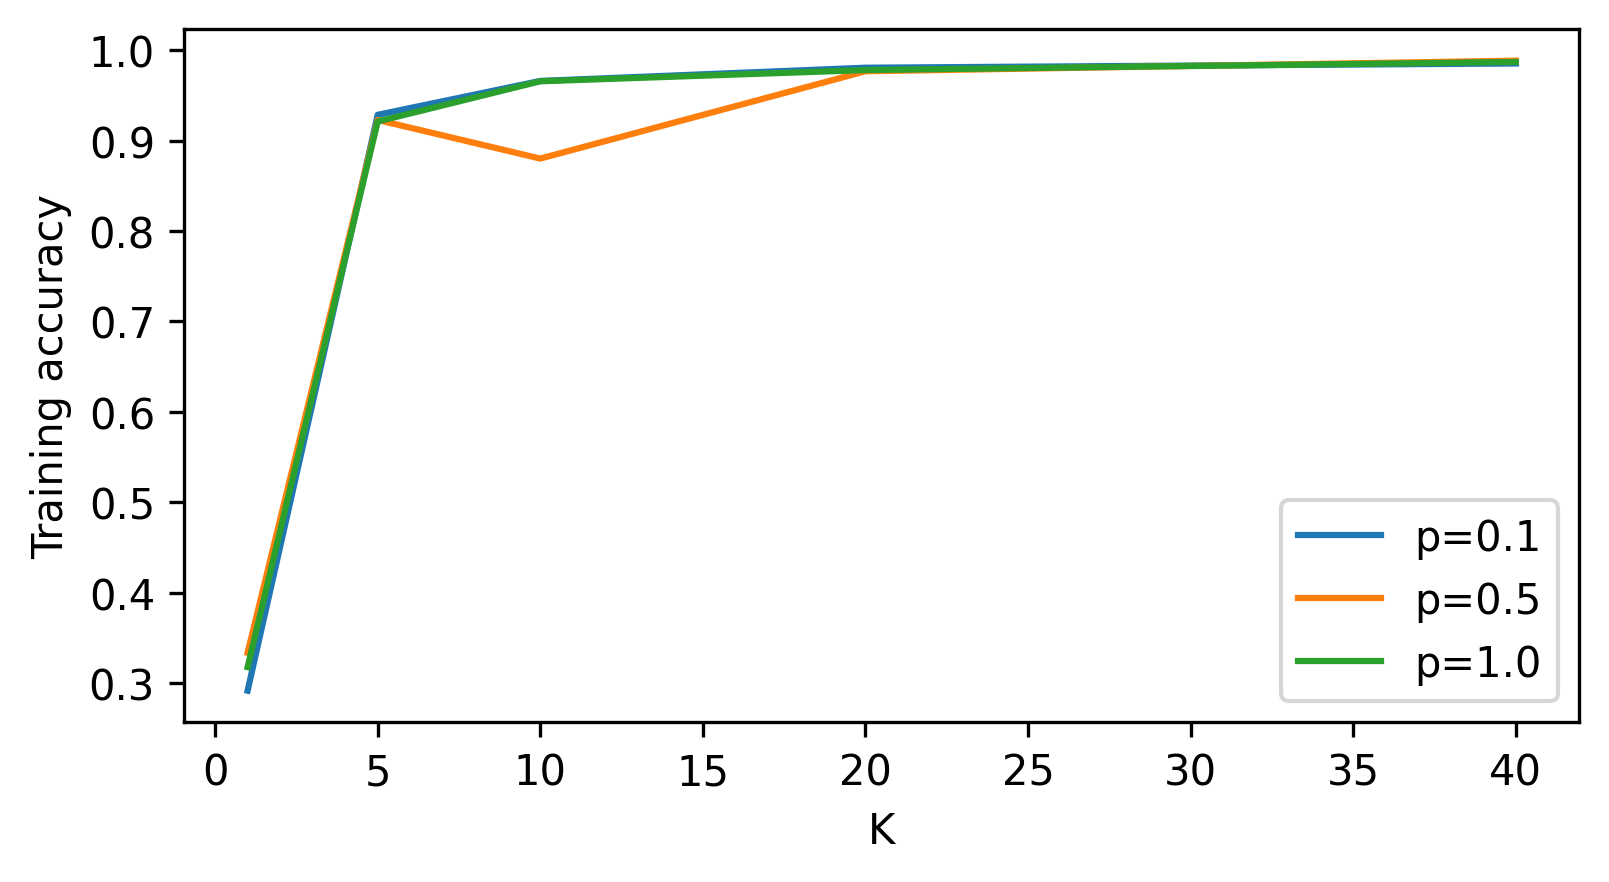

In [14]:
plt.figure(figsize=(6,3), dpi=300)

plt.plot(K, Acc_train_total[:, 0], label = "p=0.1")
plt.plot(K, Acc_train_total[:, 1], label = "p=0.5")
plt.plot(K, Acc_train_total[:, 2], label = "p=1.0")
plt.xlabel("K")
plt.ylabel("Training accuracy")
# plt.title("Training accuracy as a function of k for different $p \in P$")
plt.legend()

#### 2.3 Plot the test accuracy as a function of k and for different p ∈ P on the same plot. Does dropout help with the test accuracy? For which (k,p) configuration do you achieve the best test accuracy?

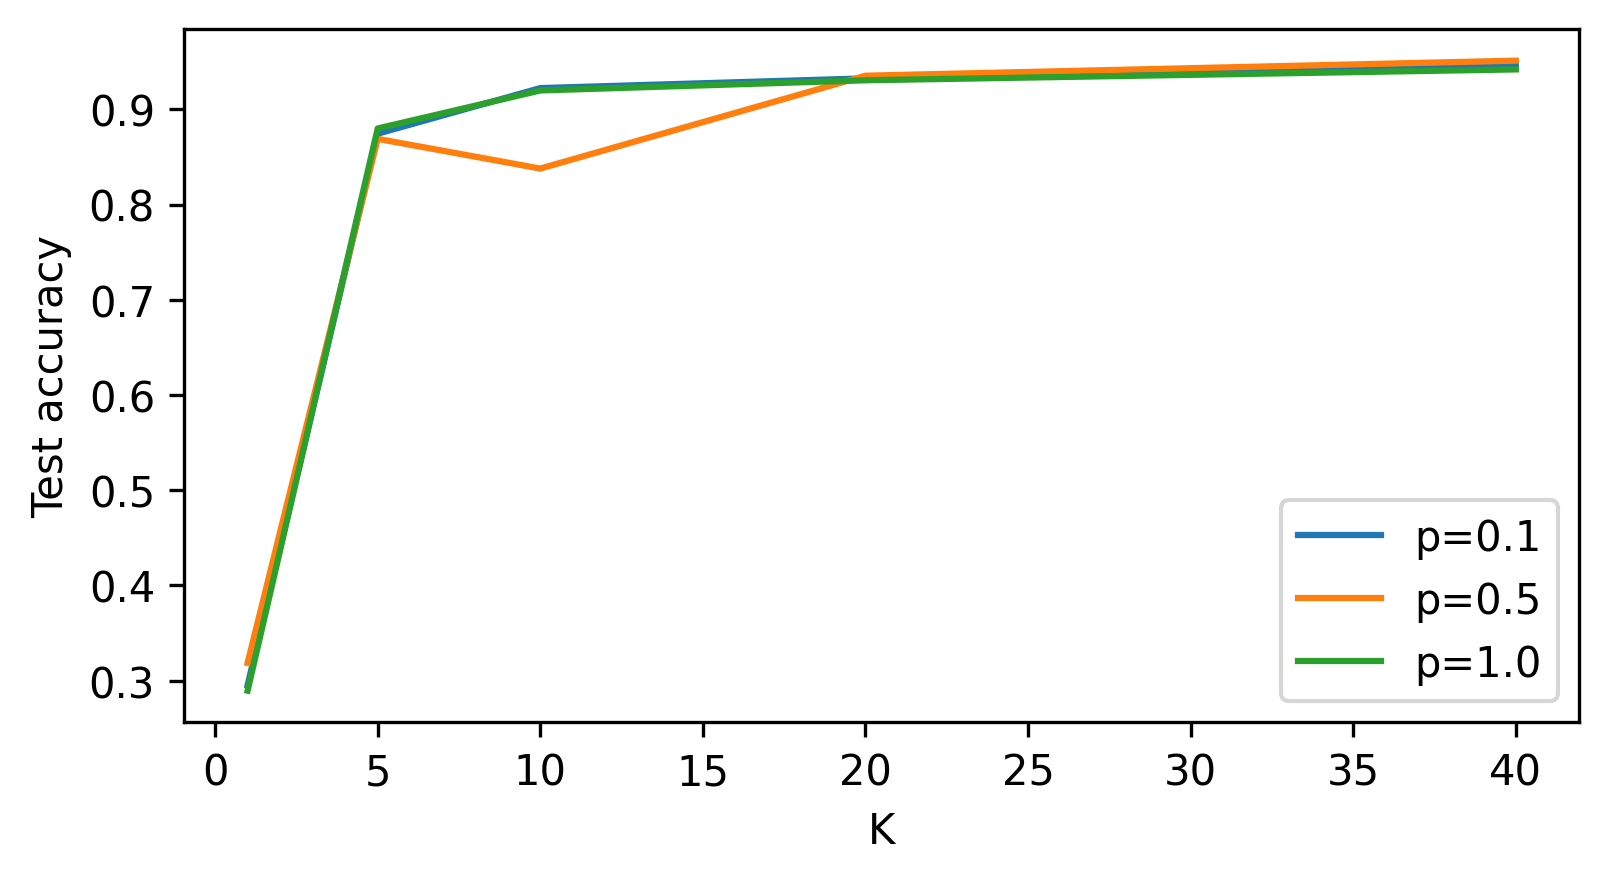

In [15]:
plt.figure(figsize=(6,3), dpi=300)

plt.plot(K, Acc_test_total[:, 0], label = "p=0.1")
plt.plot(K, Acc_test_total[:, 1], label = "p=0.5")
plt.plot(K, Acc_test_total[:, 2], label = "p=1.0")
plt.xlabel("K")
plt.ylabel("Test accuracy")
# plt.title("Test accuracy as a function of k for different $p \in P$")
plt.legend()

## Adding some noise to labels

In [16]:
# Formatting the data
X_train, y_train = Formatting_data(train = True)
X_test, y_test = Formatting_data(train = False)

sample_indices = random.sample(range(N_train), int(N_train * 0.4))
for i in sample_indices:
    y_train[i] = (y_train[i] + random.randint(1, 9)) % 10

# Use data loader
train_loader = DataLoader(dataset=ToOneHot(TensorDataset(X_train, y_train)), batch_size=batch_size, shuffle=True)

# Train the model
K = [1,5,10,20,40]
P = [0.1, 0.5, 1.0]
N_epochs = 80
train(K = K, P = P, noise=True)

K=1,P=0.1, epoch: 1, training loss: 2.3158, training acc: 9.96%, test acc: 10.28%
K=1,P=0.1, epoch: 2, training loss: 2.2830, training acc: 10.54%, test acc: 11.21%
K=1,P=0.1, epoch: 3, training loss: 2.1060, training acc: 15.37%, test acc: 19.22%
K=1,P=0.1, epoch: 4, training loss: 2.3116, training acc: 15.56%, test acc: 19.35%
K=1,P=0.1, epoch: 5, training loss: 2.3067, training acc: 15.55%, test acc: 19.36%
K=1,P=0.1, epoch: 6, training loss: 2.2757, training acc: 15.64%, test acc: 19.24%
K=1,P=0.1, epoch: 7, training loss: 2.3344, training acc: 16.07%, test acc: 19.98%
K=1,P=0.1, epoch: 8, training loss: 2.2816, training acc: 18.01%, test acc: 23.26%
K=1,P=0.1, epoch: 9, training loss: 2.2938, training acc: 18.57%, test acc: 24.07%
K=1,P=0.1, epoch: 10, training loss: 2.2953, training acc: 20.30%, test acc: 28.70%
K=1,P=0.1, epoch: 11, training loss: 2.2974, training acc: 20.43%, test acc: 28.90%
K=1,P=0.1, epoch: 12, training loss: 2.2461, training acc: 20.43%, test acc: 29.00%
K=

In [17]:
# Read the training and test acc to a table
K = [1,5,10,20,40]
P = [0.1, 0.5, 1.0]
Acc_train_total = np.zeros((len(K), len(P)))
Acc_test_total = np.zeros((len(K), len(P)))
for i, k in enumerate(K):
    for j, p in enumerate(P):
            _, Acc_train, Acc_test = torch.load("./data/result_noise_k{}_p{}".format(k, p))
            Acc_train_total[i][j] = Acc_train[-1].numpy()
            Acc_test_total[i][j] = Acc_test[-1].numpy()
Acc_train_total, Acc_test_total

(array([[0.2121    , 0.2463    , 0.1909    ],
        [0.49169999, 0.5377    , 0.53850001],
        [0.59780002, 0.59789997, 0.58639997],
        [0.60790002, 0.60500002, 0.60500002],
        [0.61440003, 0.61519998, 0.6085    ]]),
 array([[0.28999999, 0.32170001, 0.24150001],
        [0.70200002, 0.79180002, 0.78680003],
        [0.88709998, 0.88739997, 0.8739    ],
        [0.90319997, 0.8962    , 0.90380001],
        [0.91210002, 0.91070002, 0.91240001]]))

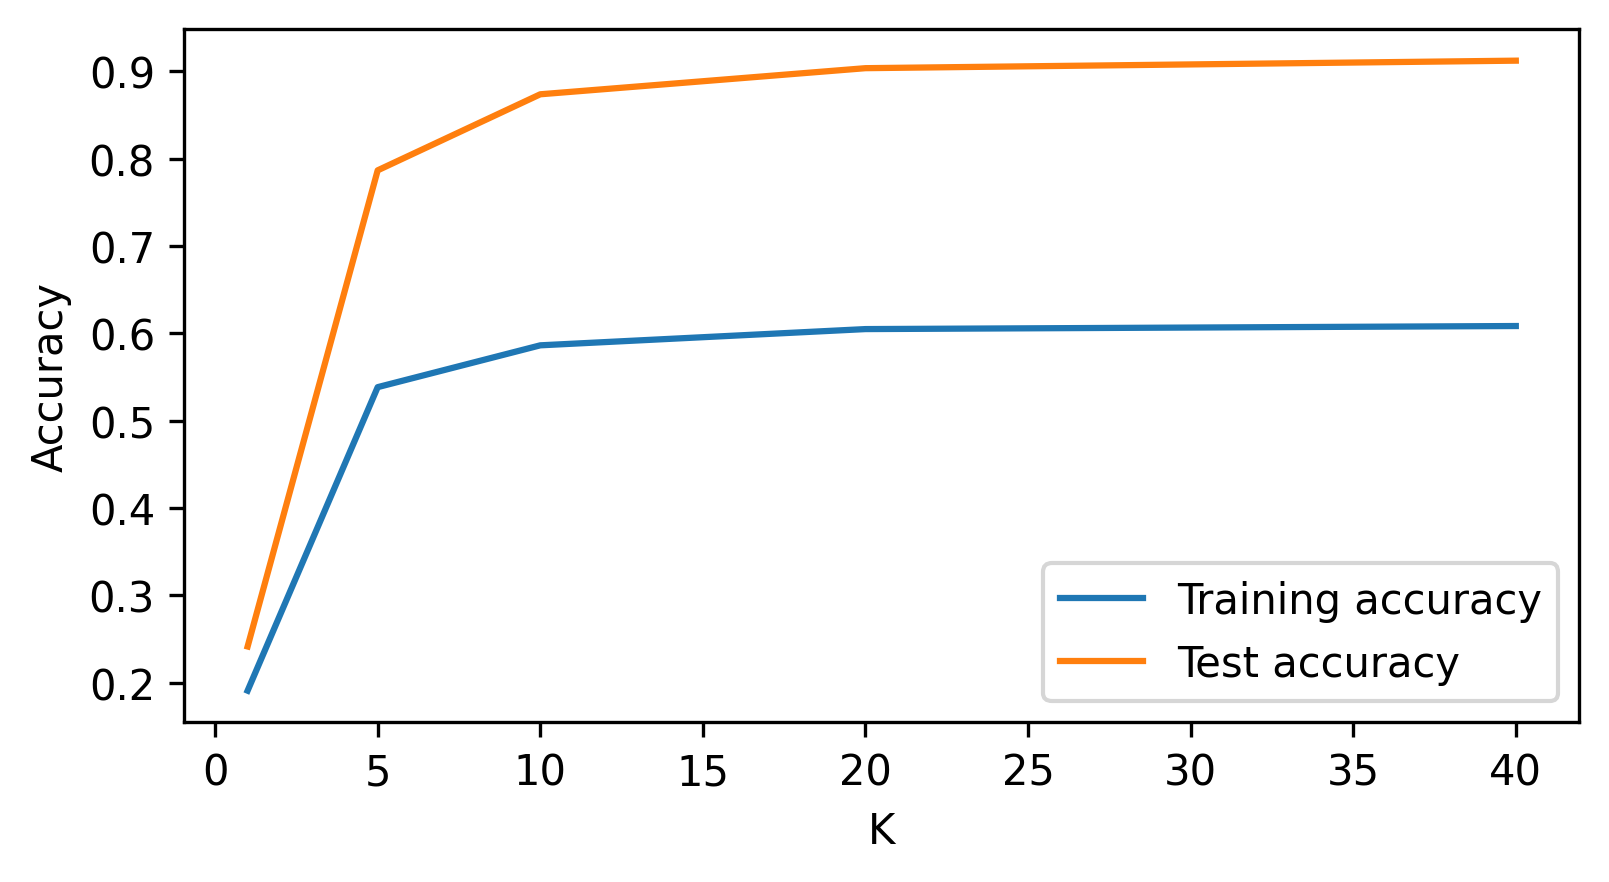

In [18]:
# Fix p = 1.0
plt.figure(figsize=(6,3), dpi=300)
plt.plot(K, Acc_train_total[:, -1], label = "Training accuracy")
plt.plot(K, Acc_test_total[:, -1], label = "Test accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
# plt.title("Training and test accuracy at p = 1.0 with adding noise")
plt.legend()

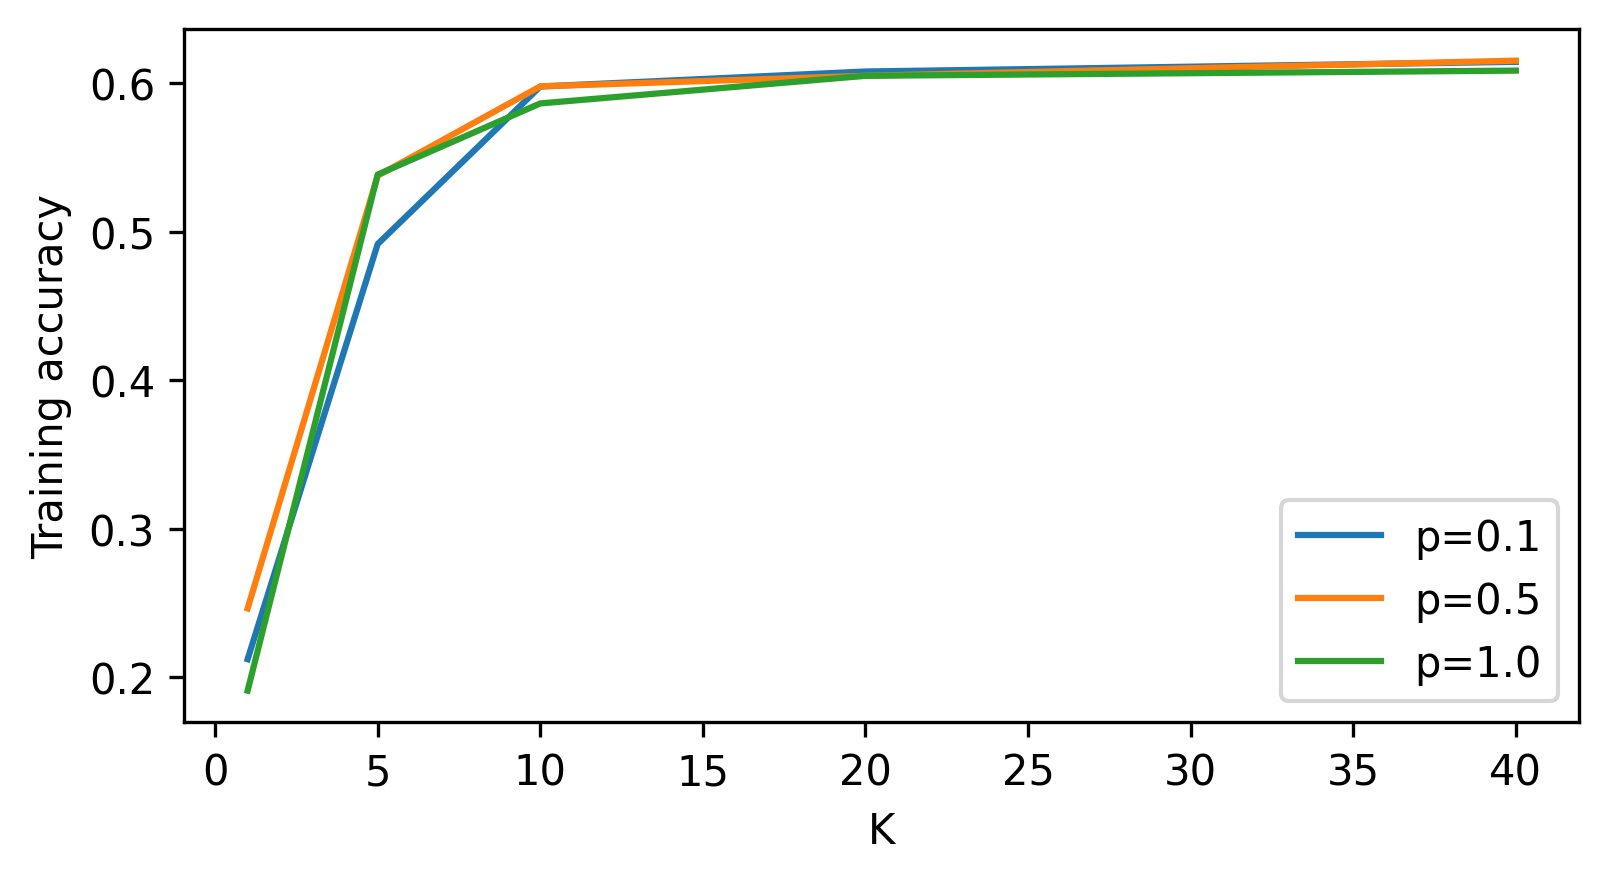

In [19]:
plt.figure(figsize=(6,3), dpi=300)
plt.plot(K, Acc_train_total[:, 0], label = "p=0.1")
plt.plot(K, Acc_train_total[:, 1], label = "p=0.5")
plt.plot(K, Acc_train_total[:, 2], label = "p=1.0")
plt.xlabel("K")
plt.ylabel("Training accuracy")
# plt.title("Training accuracy as a function of k for different $p \in P$ with adding noise")
plt.legend()

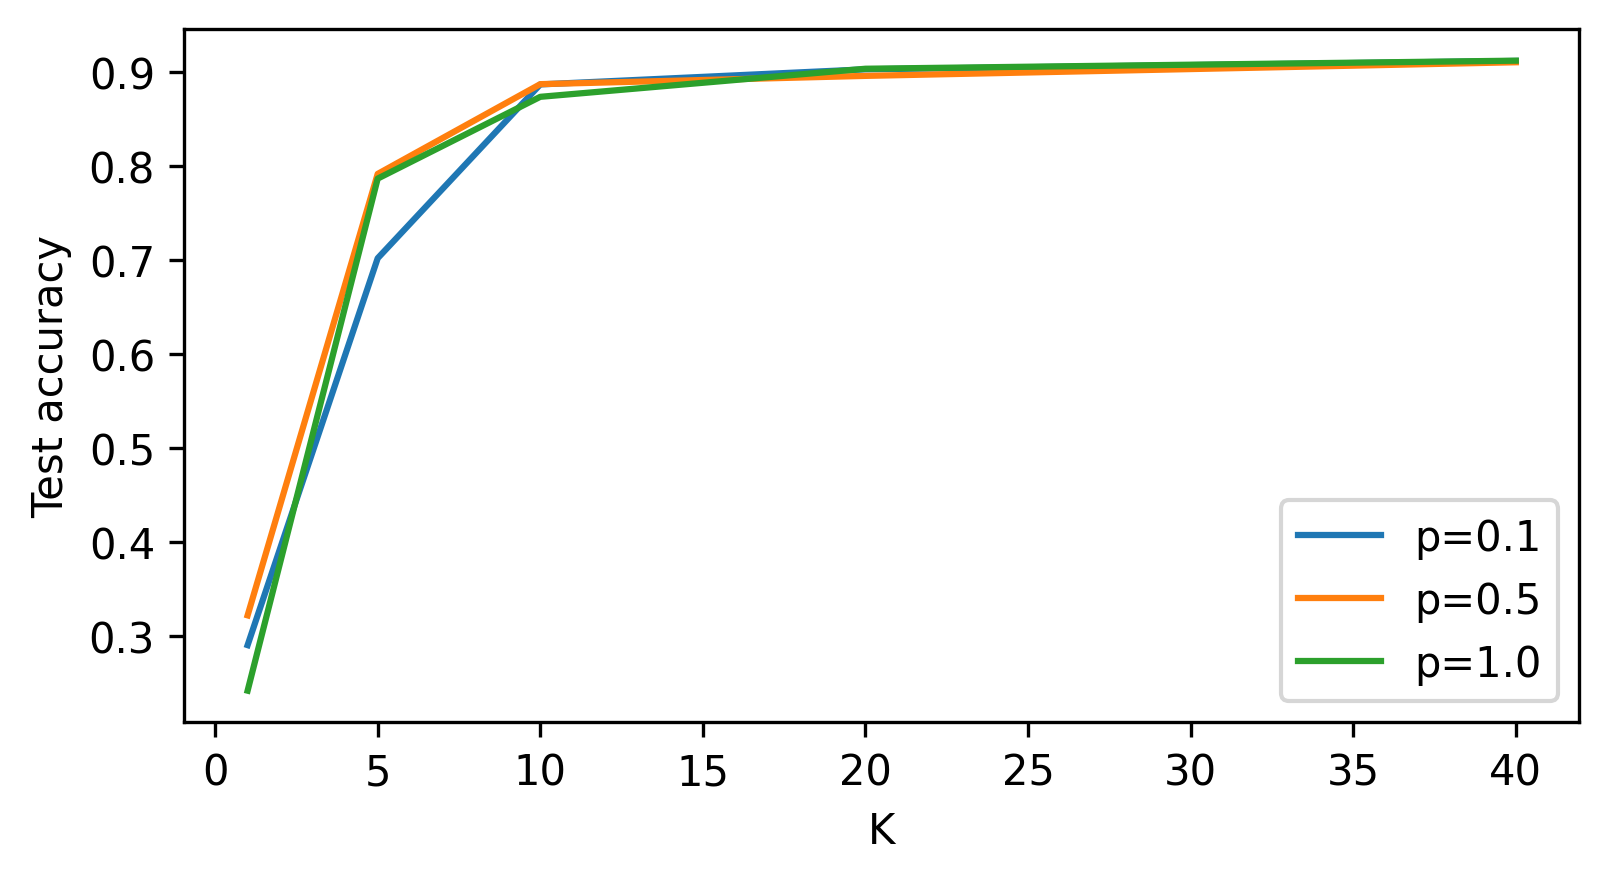

In [20]:
plt.figure(figsize=(6,3), dpi=300)

plt.plot(K, Acc_test_total[:, 0], label = "p=0.1")
plt.plot(K, Acc_test_total[:, 1], label = "p=0.5")
plt.plot(K, Acc_test_total[:, 2], label = "p=1.0")
plt.xlabel("K")
plt.ylabel("Test accuracy")
# plt.title("Test accuracy as a function of k for different $p \in P$ with adding noise")
plt.legend()